# Strangeon matter EOS generators illustration notebook

First import all the package that will be used.

In [1]:
import numpy as np
import math
import TOVsolver.main as main
import matplotlib.pyplot as plt
from scipy.integrate import ode
from EOSgenerators import EOS

from TOVsolver.unit import  km, Msun, MeV,fm

The strangeon matter EOS describes the strongly interacting matter in the solid state, and the compact star can be a self-bound quark star composed of strangeon matter. Therefore, in the following we present the bare quark star EOS without a crust.

Note that the strangeon matter parameters we input are in the natural unit system. The quentity returned by the Strangeon_compute_EOS function is in the Geometric Unit System. Thus, here, the parameter epsilon and ns are in the units of $MeV/fm^{-3}$. So follow the unite conversion rule, if we are using this unit, we just time this unit to do compute

## Defining the EOS parameters

Define the strangeon matter EOS that we will use to calculate the energy densities and pressures of the system.
The following is an example of how to define the theta and Nq.
For example, theta=[50, 0.24] means the example values for epsilon and ns:
epsilon in units of MeV, ns in units of $fm^-3$.
Nq is an integer, e.g. Nq=9, 12, 15, 18, 21, 24, 27

For the definition of parameter n, the minimum value is 3*ns/Nq, the maximum value is about 0.16*8*3/Nq.
Then we can generate,for example, 1000 points for the input of the srangeon matter EOS. Special note: If you are using this EOS, need a very fine grid for the EOS. From our test, 1000 points for this EOS is the minimum requirement

Once we define the EOS parameters already, we can use the Strangeon_compute_EOS function to calcute the energy_density and pressure.

In [6]:
Nq=18
epsilon=50
ns=0.24
theta = np.array([Nq, epsilon, ns])
n_min = 3 * theta[2] / theta[0]  
n_max = 0.16 * 8 * 3 / theta[0]   
n_values = np.linspace(n_min, n_max, 2000) 

energy_densities, pressures = EOS.Strangeon_compute_EOS(n_values, theta)
print("n values:", n_values)
print("Energy densities:", energy_densities)
print("Pressures:", pressures) 

n values: [0.04       0.04008671 0.04017342 ... 0.21315991 0.21324662 0.21333333]
Energy densities: [  204.61935484   205.0631334    205.50734538 ... 46616.1606005
 46711.98281964 46807.96367981]
Pressures: [0.00000000e+00 1.98864796e-01 4.00749542e-01 ... 1.88749504e+05
 1.89139331e+05 1.89529799e+05]


## Solve TOV with this EOS

Here below we use the strangeon matter EOS to compute the mass radius curve.

The following code calculates the mass and radius of the strange stars for the given EOS of the strange matter EOS. Since our energy_density and pressure are all in same unit $MeV/fm^{-3}$ so all we need is to time this unit

Input a given central pressure and central energy density, you will obtain the radius where the pressure is zero and the mass at that radius.

Solve the TOV equations using each central pressure and energy density

In [7]:

MR= main.OutputMR('',energy_densities* MeV/fm**3   , pressures* MeV/fm**3)




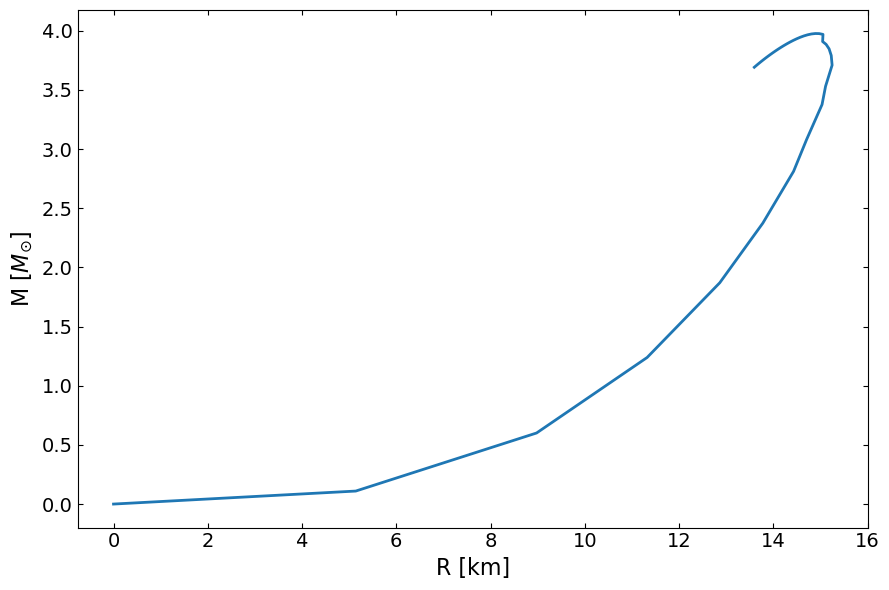

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(9, 6))
ax.plot(MR[:,0]/km , MR[:,1]/Msun, lw=2)

ax.set_ylabel(r"M [$M_{\odot}$]", fontsize=16)
ax.set_xlabel("R [km]", fontsize=16)
# ax.set_xlim(8.0, 20.0)
# ax.set_ylim(0, 3)
ax.tick_params(top=1, right=1, which="both", direction="in", labelsize=14)
ax.tick_params(top=1, right=1, which="both", direction="in", labelsize=14)
fig.tight_layout()
plt.show()